# Automatically Resampling Oblique-Acquired MRI to Enable Robust and Accurate QSM Algorithms

Ashley Stewart<sup>1</sup>, Korbinian Eckstein<sup>1</sup>, Thanh Thuy Dao<sup>1</sup>, Kieran O’Brien<sup>2</sup>, Josef Pfeuffer<sup>2</sup>, Jin Jin<sup>2</sup>, Markus Barth<sup>1</sup>, Steffen Bollmann<sup>1</sup>

<sup>1</sup>School of Information Technology and Electrical Engineering, The University of Queensland, Brisbane, Australia; 

<sup>2</sup>Siemens Healthineers Pty Ltd., Brisbane, Australia

## Introduction

In an MRI acquisition, oblique slice orientations are often used to visualise clinically relevant anatomical regions and optimise the scanning field of view and duration. In Quantitative Susceptibility Mapping (QSM), which aims to estimate the magnetic susceptibility of tissues, many emerging algorithms assume that the main magnetic field is oriented axially through the imaging volume, which is not the case for oblique acquisitions. This assumption prevents accurate susceptibility quantification and introduces pervasive artefacts in susceptibility maps, limiting the practical uptake of the method. Recent work has identified resampling slices to an axial orientation prior to QSM processing as a solution<sup>1</sup>. In this work, we implement this rotate-and-resample method to enable automated processing of oblique acquisitions and publish it as part of the QSMxT software toolbox<sup>2,3</sup>. We test the implementation in silico using the QSM challenge head phantom, measuring differences in the effect of orientation on susceptibility quantification across brain regions, identifying that small sources such as veins remain challenging to quantify accurately after resampling.

In [19]:
# Necessary imports
import os
import glob
import tempfile
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import abstract_functions as fn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse

## Methods

### Data

The QSM challenge 2.0 *in silico* head phantom<sup>4</sup> was used for this experiment and is based on a segmented MP2RAGE dataset with 0.64 mm<sup>3</sup> isotropic resolution down-sampled to 1 mm<sup>3</sup> using k-space cropping and TEs=4/12/20/28 ms. The magnitude and phase were augmented by rotation about the $x$-axis to produce new datasets with effective B<sub>0</sub> directions at 5° increments up to 45°.

In [27]:
# Download input data
bids_dir = fn.get_bids_data()
print(f"Downloaded in silico head phantom data to {bids_dir}.")

Downloaded in silico head phantom data to /tmp/bids-osf.


In [28]:
# Acquisition and reconstruction parameters
echo_times = [0.004, 0.012, 0.020, 0.028]
magnetic_field_strength = 3
tgvqsm_erosions = 3
bet_fractional_intensity = 0.5

In [22]:
# Get relevant paths and find input images
session_path = os.path.join(bids_dir, "sub-1", "ses-1")
anat_path = os.path.join(session_path, "anat")
extra_data_path = os.path.join(session_path, "extra_data")
chi_file = os.path.join(extra_data_path, "sub-1_ses-1_run-01_chi-cropped.nii.gz")
segmentation_file = os.path.join(extra_data_path, "sub-1_ses-1_run-01_segmentation.nii.gz")
mag_files = sorted(glob.glob(os.path.join(anat_path, "sub-1_ses-1_run-01_echo-*_part-mag_MEGRE.nii.gz")))
pha_files = sorted(glob.glob(os.path.join(anat_path, "sub-1_ses-1_run-01_echo-*_part-phase_MEGRE.nii.gz")))
assert(len(mag_files) == len(pha_files))
tmp_dir = tempfile.gettempdir()
print(f"Found {len(mag_files)} magnitude and phase image pairs.")

Found 4 magnitude and phase image pairs.


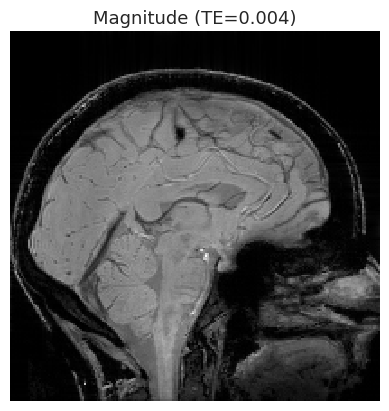

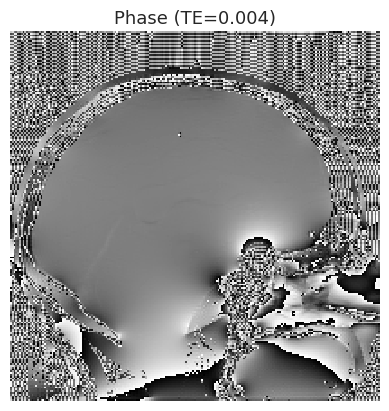

In [23]:
# View some input data
fn.display_nii(mag_files[0], title=f'Magnitude (TE={echo_times[0]})', cmap='gray', interpolation='nearest')
fn.display_nii(pha_files[0], title=f'Phase (TE={echo_times[0]})', cmap='gray', interpolation='nearest')

Creating rotated input images (1°)
Creating rotated input images (2°)
Creating rotated input images (3°)
Creating rotated input images (4°)
Creating rotated input images (5°)
Creating rotated input images (10°)
Creating rotated input images (15°)
Creating rotated input images (20°)
Creating rotated input images (25°)
Creating rotated input images (30°)
Creating rotated input images (35°)
Creating rotated input images (40°)
Creating rotated input images (45°)


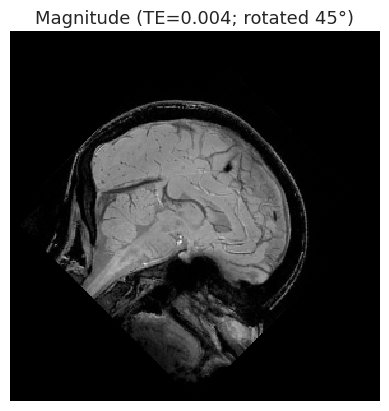

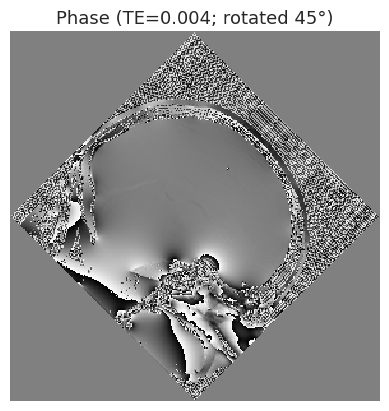

In [26]:
# Create augmented (rotated) data
degrees = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45]
for d in degrees:
    print(f"Creating rotated input images ({d}°)")
    out_dir = os.path.join(tmp_dir, f"inputs-rotated-{d}-degrees")
    mag_rotated, pha_rotated = fn.rotate_mag_phase(mag_files, pha_files, out_dir, d)

In [ ]:
# View some of the augmented data
fn.display_nii(mag_rotated[0], title=f'Magnitude (TE={echo_times[0]}; rotated {degrees[-1]}°)', cmap='gray', interpolation='nearest')
fn.display_nii(pha_rotated[0], title=f'Phase (TE={echo_times[0]}; rotated {degrees[-1]}°)', cmap='gray', interpolation='nearest')

### Processing

Magnitude and phase data were resampled to an axial affine through the complex domain using nilearn prior to QSM processing using TGV-QSM5. The susceptibility maps were then resampled back to the original orientation. In QSMxT, this process occurs automatically when the obliquity, measured using nibabel, is greater than a user-defined threshold.

BET masking for original data...
QSM reconstruction for original data...


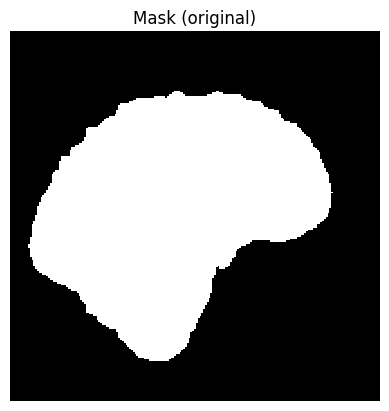

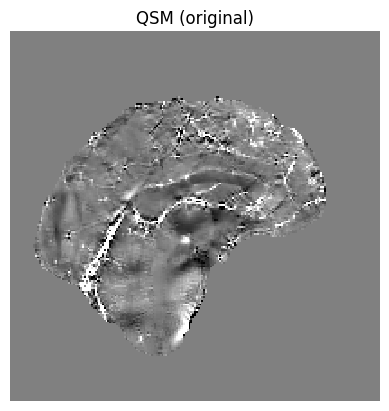

In [7]:
# First process the original (0-degrees rotated) data
print("BET masking for original data...")
mask_file = fn.bet_masking(mag_files[0], bet_fractional_intensity, extra_data_path)
print("QSM reconstruction for original data...")
qsm_average_file = fn.tgv_qsm_me(mask_file, pha_files, echo_times, magnetic_field_strength, tgvqsm_erosions, extra_data_path)
fn.display_nii(mask_file, title='Mask (original)', cmap='gray', interpolation='nearest')
fn.display_nii(qsm_average_file, title='QSM (original)', cmap='gray', vmin=-0.05, vmax=+0.05, interpolation='nearest')

In [12]:
# Now process the augmented/rotated data
result_files = { }
for d in degrees:
    out_dir = os.path.join(extra_data_path, f"inputs-rotated-{d}-degrees")
    mag_rotated, pha_rotated = fn.rotate_mag_phase(mag_files, pha_files, out_dir, d)
    mag_rotated_axial, pha_rotated_axial = fn.resample_to_axial(mag_rotated, pha_rotated, out_dir)

    print("BET masking rotated data...")
    mask_rotated = fn.bet_masking(mag_rotated[0], bet_fractional_intensity, out_dir)
    print("Reconstructing QSM for rotated data...")
    qsm_rotated_average = fn.tgv_qsm_me(mask_rotated, pha_rotated, echo_times, magnetic_field_strength, tgvqsm_erosions, out_dir)
    #qsm_rotated_average = nextqsm_me(mask_rotated, pha_rotated, TEs, B0_str, eros, out_dir) #TODO REMOVE
    print("Resampling QSM to original space...")
    qsm_rotated_average_resampled_file = fn.resample_like(qsm_rotated_average, mag_files[0])

    print("BET masking resampled-to-axial data...")
    mask_rotated_axial = fn.bet_masking(mag_rotated_axial[0], bet_fractional_intensity, out_dir)
    print("Reconstructing QSM for resampled-to-axial data...")
    qsm_rotated_axial_average = fn.tgv_qsm_me(mask_rotated_axial, pha_rotated_axial, echo_times, magnetic_field_strength, tgvqsm_erosions, out_dir)
    #qsm_rotated_axial_average = nextqsm_me(mask_rotated_axial, pha_rotated_axial, TEs, B0_str, eros, out_dir)
    print("Resampling QSM to original space...")
    qsm_rotated_axial_average_resampled_file = fn.resample_like(qsm_rotated_axial_average, mag_files[0])
    
    result_files[d] = [qsm_rotated_axial_average_resampled_file, qsm_rotated_average_resampled_file]

Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-1.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-1_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-03_part-mag_MEGRE_rot-1.nii.gz...
Loading ph

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-1_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-1_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-1-degrees/su

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-2.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-2_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
L

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-2_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-2_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-2-degrees/su

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-3.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-3_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
L

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-3_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-3_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-3-degrees/su

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-4.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-4_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
L

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-4_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-4_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-4-degrees/su

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-5.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-5_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
L

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_qsm_000.nii.gz
Finished!


  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/su

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-5_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-5_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-5-degrees/su

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-10.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-10_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-10_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-10_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-10

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-15.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-15_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-15_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-15_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-15

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-20.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-20_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-20_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-20_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-20

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-25.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-25_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-25_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-25_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-25

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-30.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-30_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-30_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-30_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-30

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-35.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-35_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-35_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-35_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-35

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-40.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-40_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-40_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-40_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-40

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
Loading mag=sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_resampled-axial.nii.gz
Loading mag=sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-45.nii.gz...
Loading pha=sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45.nii.gz...
Resampling to true axial...
Saving mag=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-mag_MEGRE_rot-45_resampled-axial.nii.gz
Saving pha=/tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-ax

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_qsm_000.nii.gz
Finis

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!
BET masking resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg bet /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial.nii.gz /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet.nii.gz -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz -f 0.5
[ 99%] BET: Performing 991 of 1000 iterations.		Reconstructing QSM for resampled-to-axial data...
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.004 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degre

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.012 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-02_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.02 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-03_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45

  Iterations: 1000 (1 of 1)
singularity exec /neurocommand/local/containers/qsmxt_1.1.13_20221020/qsmxt_1.1.13_20221020.simg tgv_qsm -t 0.028 --alpha 0.0015 0.0005  -i 1000 -f 3 -e 3 --ignore-orientation --no-resampling -m /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz -o _qsm -p /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_resampled-axial.nii.gz


 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_resampled-axial.nii.gz
  mask:  /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-01_part-mag_MEGRE_rot-45_resampled-axial_bet-mask.nii.gz
  output: /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_resampled-axial_qsm_{number:03d}.nii.gz
Data looks good!
Processing initial laplacian of /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Processing QSM /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45-degrees/sub-1_ses-1_run-01_echo-04_part-phase_MEGRE_rot-45_resampled-axial.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Saved /tmp/bids-osf/sub-1/ses-1/extra_data/inputs-rotated-45

  Iterations: 1000 (1 of 1)
Resampling QSM to original space...*] 100.0% Done!


### Measurements

RMSE was measured across brain regions defined by segmentations provided with the original head phantom.

In [14]:
# Segmentation labels
labels = { 
    1 : "Caudate",
    2 : "Globus pallidus",
    3 : "Putamen",
    4 : "Red nucleus",
    5 : "Dentate nucleus",
    6 : "SN and STN",
    7 : "Thalamus",
    8 : "White matter",
    9 : "Gray matter",
    10 : "CSF",
    11 : "Blood",
    12 : "Fat",
    13 : "Bone",
    14 : "Air",
    15 : "Muscle",
    16 : "Calcification"
}

# Load ground truth data
segmentation = np.rot90(nib.load(segmentation_file).get_fdata())
chi = np.rot90(nib.load(chi_file).get_fdata())
qsm_average = np.rot90(nib.load(qsm_average_file).get_fdata())
chi = chi * (qsm_average != 0)
mask = qsm_average != 0

# Calculate RMSE
print("Calculating error metrics...")
columns = ["Rotation", "Segmentation", "Corrected", "RMSE"]
rmse = np.array([0, 0, 0, mse(chi[mask], qsm_average[mask], squared=False)]).reshape(1,4)
rmse = np.append(rmse, np.array([0, 0, 1, mse(chi[mask], qsm_average[mask], squared=False)]).reshape(1,4), axis=0)
for label_id in labels.keys():
    if np.any(chi[segmentation == label_id]):
        rmse = np.append(rmse, np.array([0, label_id, 1, mse(chi[segmentation == label_id], qsm_average[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
        rmse = np.append(rmse, np.array([0, label_id, 0, mse(chi[segmentation == label_id], qsm_average[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
for d in degrees:
    print(f"Calculating error metrics for d={d}")
    qsm_corrected = np.rot90(nib.load(result_files[d][0]).get_fdata())
    qsm_uncorrected = np.rot90(nib.load(result_files[d][1]).get_fdata())
    rmse = np.append(rmse, np.array([d, 0, 1, mse(chi[mask], qsm_corrected[mask], squared=False)]).reshape(1,4), axis=0)
    rmse = np.append(rmse, np.array([d, 0, 0, mse(chi[mask], qsm_uncorrected[mask], squared=False)]).reshape(1,4), axis=0)
    for label_id in labels.keys():
        if np.any(chi[segmentation == label_id]):
            rmse = np.append(rmse, np.array([d, label_id, 1, mse(chi[segmentation == label_id], qsm_corrected[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
            rmse = np.append(rmse, np.array([d, label_id, 0, mse(chi[segmentation == label_id], qsm_uncorrected[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
rmse = pd.DataFrame(data=rmse, columns=columns)
rmse["Corrected"] = rmse["Corrected"].replace(0, "NoRot").replace(1, "RotPrior")

Calculating error metrics...
Calculating error metrics for d=1
Calculating error metrics for d=2
Calculating error metrics for d=3
Calculating error metrics for d=4
Calculating error metrics for d=5
Calculating error metrics for d=10
Calculating error metrics for d=15
Calculating error metrics for d=20
Calculating error metrics for d=25
Calculating error metrics for d=30
Calculating error metrics for d=35
Calculating error metrics for d=40
Calculating error metrics for d=45


## Results

RMSE measured in the head phantom indicates that the rotate-and-resample method (RotPrior) provides stable RMSEs across brain regions except in blood and CSF (see Figure 1). Conversely, no corrections (NoRot) cause increasing RMSE with the degree of rotation, particularly in deep gray matter (dGM) nuclei.

Creating line plot...


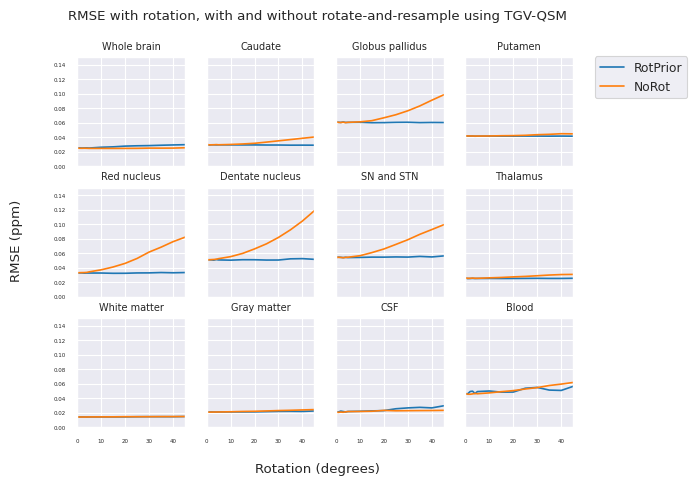

In [15]:
print("Creating line plot...")
sns.set_style("darkgrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":7,"axes.labelsize":5})
fig, axes = plt.subplots(3,4)
fig.suptitle('RMSE with rotation, with and without rotate-and-resample using TGV-QSM')
fig.supxlabel('Rotation (degrees)')
fig.supylabel('RMSE (ppm)')
index = 0
for label_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    ylim=(0.0, 0.15)
    xlim=(0, 45)
    ax = axes[int(index / 4), index % 4]
    plot = sns.lineplot(ax=ax, data=rmse[rmse.Segmentation == label_id], x="Rotation", y="RMSE", hue="Corrected")
    plot.set(xlabel=None)
    plot.set(ylabel=None)
    plot.set(ylim=ylim, xlim=xlim, title=labels[label_id] if label_id in labels else "Whole brain")
    if index < 8:
        plot.set(xticklabels=[])
    if index % 4 != 0:
        plot.set(yticklabels=[])
    plot.tick_params(axis='both', which='major', labelsize=4)
    plot.tick_params(axis='both', which='minor', labelsize=4)
    plt.xlabel("")
    plot.get_legend().remove()
    index += 1
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles, labels, loc=(1.2, 3.025))
#plt.savefig(f"lineplot.png", dpi=700, bbox_inches='tight')
plt.show()
plt.close()

Difference imaging visualises the spatial distribution of changes in susceptibility quantification and smearing artefacts in dGM regions as the degree of rotation increases (see Figure 2). 

Creating diff image figure...


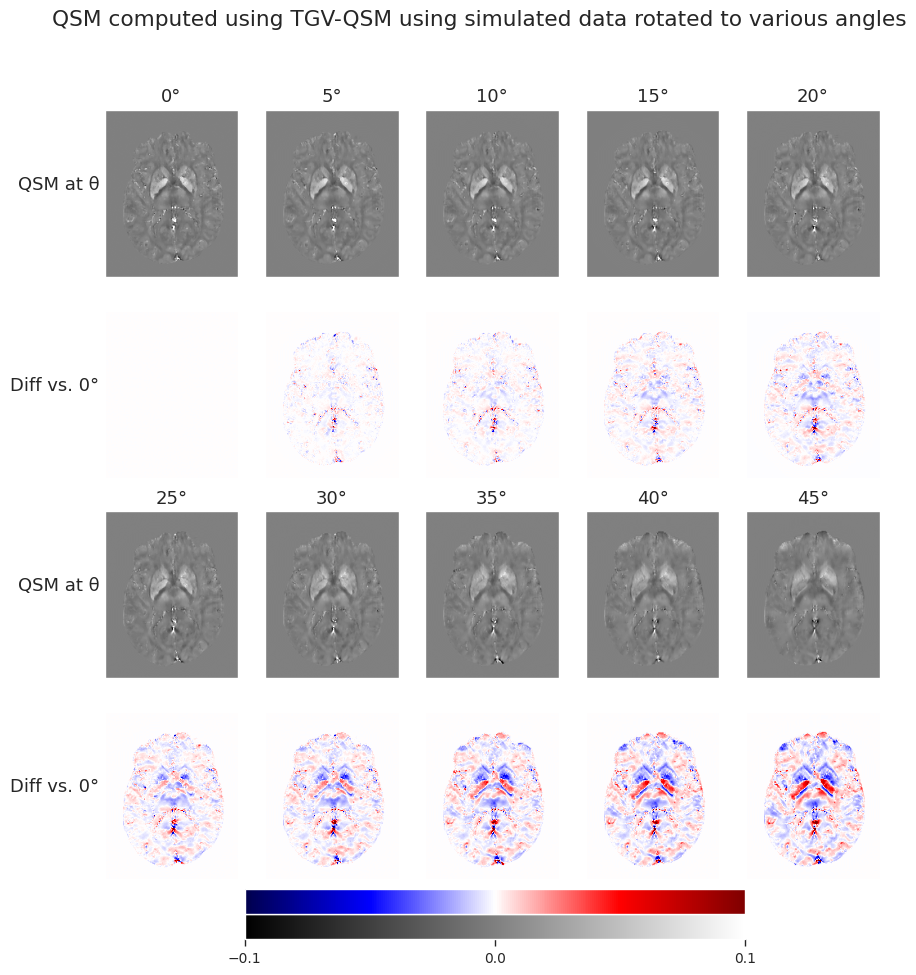

In [17]:
print("Creating diff image figure...")
#plt.figure()
sns.set_style("darkgrid")
sns.set_context("paper", rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13})
fig, axes = plt.subplots(4, 5, figsize=[10,10])
fig.suptitle('QSM computed using TGV-QSM using simulated data rotated to various angles')
slc = 102
vmin = -0.1
vmax = +0.1

axes[0,0].set_ylabel("QSM at θ", rotation=0, horizontalalignment='right')
axes[0,0].set_title("0°")
axes[0,0].imshow(qsm_average[:,:,slc], cmap='gray', vmin=vmin, vmax=vmax)
axes[0,1].set_title("5°")
axes[0,1].imshow(np.rot90(nib.load(result_files[5][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,2].set_title("10°")
axes[0,2].imshow(np.rot90(nib.load(result_files[10][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,3].set_title("15°")
axes[0,3].imshow(np.rot90(nib.load(result_files[15][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,4].set_title("20°")
axes[0,4].imshow(np.rot90(nib.load(result_files[20][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)

axes[1,0].set_ylabel("Diff vs. 0°", rotation=0, horizontalalignment='right')
axes[1,0].imshow(qsm_average[:,:,slc] - qsm_average[:,:,slc], cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,1].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[5][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,2].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[10][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,3].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[15][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,4].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[20][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)

axes[2,0].set_title("25°")
axes[2,0].set_ylabel("QSM at θ", rotation=0, horizontalalignment='right')
axes[2,0].imshow(np.rot90(nib.load(result_files[25][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,1].set_title("30°")
axes[2,1].imshow(np.rot90(nib.load(result_files[30][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,2].set_title("35°")
axes[2,2].imshow(np.rot90(nib.load(result_files[35][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,3].set_title("40°")
axes[2,3].imshow(np.rot90(nib.load(result_files[40][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,4].set_title("45°")
im1 = axes[2,4].imshow(np.rot90(nib.load(result_files[45][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)

axes[3,0].set_ylabel("Diff vs. 0°", rotation=0, horizontalalignment='right')
axes[3,0].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[25][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,1].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[30][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,2].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[35][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,3].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[40][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
im2 = axes[3,4].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[45][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)

for row in axes:
    for ax in row:
        ax.tick_params(which='both', left=False, right=False, labelbottom=False, labelleft=False, grid_alpha=0)

cax1 = fig.add_axes([0.265,0.050,0.5,0.025])
cax2 = fig.add_axes([0.265,0.075,0.5,0.025])
cax1.set_frame_on(True)
cax2.set_frame_on(True)
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cax1)
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cax2)
cbar2.set_ticks([])
cbar1.ax.locator_params(nbins=3)
cbar2.ax.locator_params(nbins=3)
cbar1.ax.tick_params(labelsize=10)
cbar2.ax.tick_params(labelsize=10)

#plt.savefig(f"diff-images.png", dpi=700, bbox_inches='tight')
plt.show()
plt.close()

## Discussion and conclusions

Our experiment validates that the rotate-and-resample method1 results in stable susceptibility quantification across most brain regions. Further, small, high-susceptibility sources such as blood in veins were found to be more challenging to recover after resampling, which may be explained by reduced phase accuracy after interpolation in the complex domain. Our publicly available implementation of the method in QSMxT makes it available and practical for users wishing to reconstruct QSM for acquisitions with oblique slice orientations.

## References

1] Kiersnowski et al. ISMRM 2021, Abstract 794. 2] Stewart et al., Mag. Reson. Med., 2022. 3] Stewart et al., QSMxT, GitHub, 2022. 4] Marques et al., Mag. Reson. Med., 2021. 6] Langkammer et al., NeuroImage, 2015.